In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from termcolor import colored
from statsmodels.tsa.deterministic import DeterministicProcess
import datetime

In [95]:
fpth = 'data/tunnel.csv'
time_column = 'Day'
cols_to_drop = None

df = pd.read_csv(fpth, index_col= time_column, parse_dates = True)
if cols_to_drop:
    df = df.drop(cols_to_drop, axis=1)
df = df.to_period() # required to make `out_of_sample` to work properly # change df.index to df.index.to_timestamp() while plotting
df.head(3)

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795


In [96]:
df.index

PeriodIndex(['2003-11-01', '2003-11-02', '2003-11-03', '2003-11-04',
             '2003-11-05', '2003-11-06', '2003-11-07', '2003-11-08',
             '2003-11-09', '2003-11-10',
             ...
             '2005-11-07', '2005-11-08', '2005-11-09', '2005-11-10',
             '2005-11-11', '2005-11-12', '2005-11-13', '2005-11-14',
             '2005-11-15', '2005-11-16'],
            dtype='period[D]', name='Day', length=747)

In [97]:
moving_avg = df['NumVehicles'].rolling(window=365, min_periods=183, center = False).mean()
moving_avg

Day
2003-11-01              NaN
2003-11-02              NaN
2003-11-03              NaN
2003-11-04              NaN
2003-11-05              NaN
                  ...      
2005-11-12    109766.939726
2005-11-13    109755.002740
2005-11-14    109811.117808
2005-11-15    109820.284932
2005-11-16    109829.706849
Freq: D, Name: NumVehicles, Length: 747, dtype: float64

2


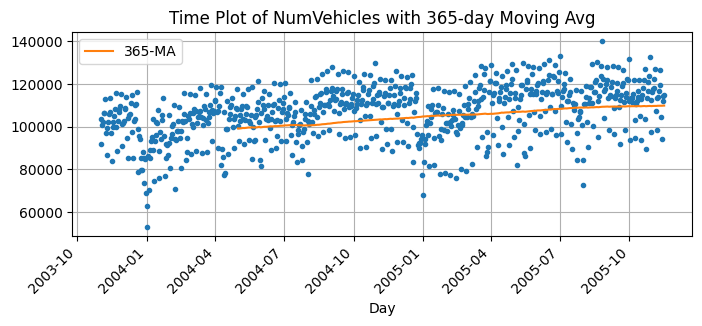

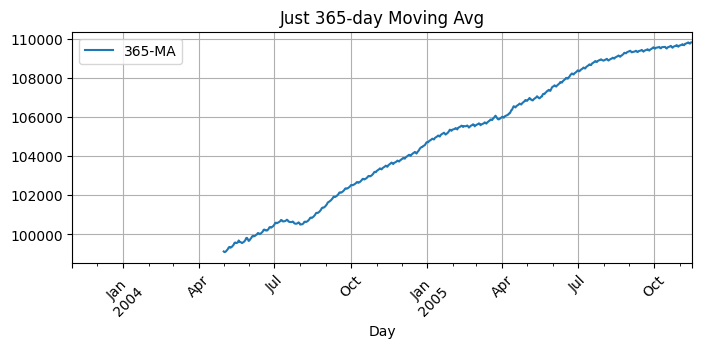

In [102]:
fig, ax = plt.subplots(figsize = (8,3))
if isinstance(df.index[0], pd.Timestamp):
    print('1')
    ax.plot(df.index, df.NumVehicles, '.') # scatter
if isinstance(df.index[0], pd.Period):
    print('2')
    ax.plot(df.index.to_timestamp(), df.NumVehicles, '.') # scatter  
#ax.plot(df.index, df.NumVehicles) # line
moving_avg.plot(ax=ax, label='365-MA')
ax.tick_params(axis="x", rotation = 45)
ax.set_title('Time Plot of NumVehicles with 365-day Moving Avg')
ax.grid()
ax.legend()

fig, ax = plt.subplots(figsize = (8,3))
moving_avg.plot(ax=ax, label='365-MA')
ax.tick_params(axis="x", rotation = 45)
ax.set_title('Just 365-day Moving Avg')
ax.grid()
ax.legend()

#### Create both Time-step & Lag features 

In [103]:
# Before creating Time-step & Lag features, check for missing dates, to understand how to create those features
startDate = df.index[0]
endDate = df.index[-1]
available_dates = df.index
if isinstance(startDate, pd.Timestamp):
    print('Type is Timestamp')
if isinstance(startDate, pd.Period):
    print('Type is Period')
    startDate = startDate.to_timestamp()
    endDate = endDate.to_timestamp()
    available_dates = df.index.to_timestamp()
    
print(f'Start date in df: {startDate}\nEnd date in df: {endDate}')

# because we have data for each day, hence, freq = D
possible_dates = pd.date_range(start = startDate, end = endDate, freq='D')
missing_dates = possible_dates.difference(available_dates)
print(f'Total missing dates are : {len(missing_dates)}')
if len(missing_dates)>=1:
    print('Missing dates: ', missing_dates)

Type is Period
Start date in df: 2003-11-01 00:00:00
End date in df: 2005-11-16 00:00:00
Total missing dates are : 0


In [104]:
dp = DeterministicProcess(
    index = df.index, # dates from training data
    constant= True, # dummy feature for bias
    order = 3, # order of Trendline 1-linear, 2-quadratic
    drop = True # check for perfect collinearity and drop any linearly dependent terms
)

X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
Day,,,,
2003-11-01,1.0,1.0,1.0,1.0
2003-11-02,1.0,2.0,4.0,8.0
2003-11-03,1.0,3.0,9.0,27.0
2003-11-04,1.0,4.0,16.0,64.0
2003-11-05,1.0,5.0,25.0,125.0


X.shape, y.shape:  (747, 4) (747,)
Linear Regression score: 0.15602032043022862 
MSE: 130777145.98172598 
NumVehicles = 0.0 + 95373.76318351013 x const + 56.84781993877068 x trend + -0.09441978011096006 x trend_squared + 7.207139886844516e-05 x trend_cubed

2


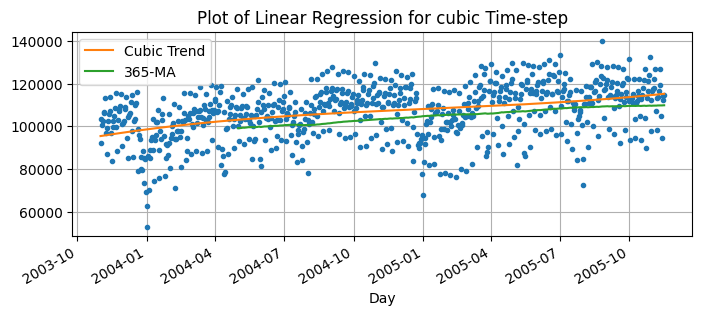

In [106]:
y = df['NumVehicles']

print('X.shape, y.shape: ', X.shape, y.shape)
#print('X:\n', X.head(2), '\n\ny: \n', y.head(2))

# Model
lr = LinearRegression(fit_intercept=False) # because x0=1 term is present in X
lr.fit(X,y)
print(colored(f'Linear Regression score: {lr.score(X, y)} ', 'red', attrs=['bold']))

# Predictions
y_pred = lr.predict(X)

# make preds as a dataframe
y_pred = pd.Series(y_pred, index = X.index)
#print('\n\nPredictions:\n', y_pred.head(2))
print(colored(f'MSE: {mean_squared_error(y, y_pred)} ', 'red', attrs=['bold']))

# Equation
formula = f'NumVehicles = {lr.intercept_}'
for i in range(X.shape[1]):
    formula += f' + {lr.coef_[i]} x {list(X.columns)[i]}'

print(colored(formula, 'red', attrs=['bold']))
print()
fig, ax = plt.subplots(figsize=(8,3))
if isinstance(df.index[0], pd.Timestamp):
    print('1')
    ax.plot(df.index, df.NumVehicles, '.') # scatter
if isinstance(df.index[0], pd.Period):
    print('2')
    ax.plot(df.index.to_timestamp(), df.NumVehicles, '.') # scatter  
y_pred.plot(ax=ax, label = 'Cubic Trend')
moving_avg.plot(ax=ax, label='365-MA')
ax.set_title(f'Plot of Linear Regression for cubic Time-step')
ax.grid()
ax.legend()
plt.show()

Now, let's make future predictions using __"out of sample"__ features. It generates future dates.

In [108]:
X = dp.out_of_sample(steps=30) # 30 new more days
y_fore = pd.Series(lr.predict(X), index = X.index)
y_fore.head(3)

2005-11-17    115230.216339
2005-11-18    115266.852256
2005-11-19    115303.623223
Freq: D, dtype: float64

2


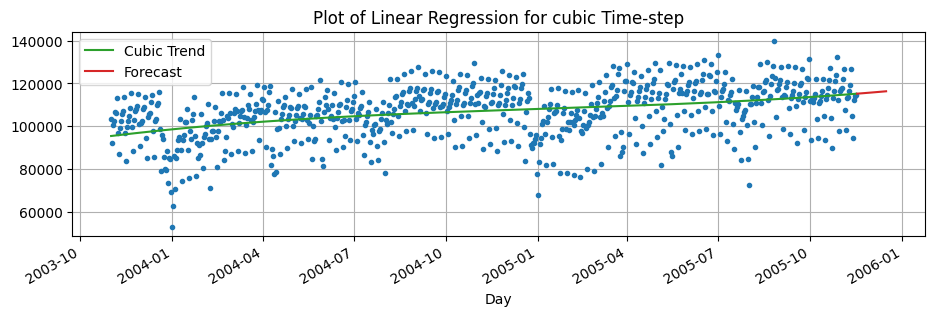

In [119]:
fig, ax = plt.subplots(figsize=(11,3))
if isinstance(df.index[0], pd.Timestamp):
    print('1')
    ax.plot(df.index, df.NumVehicles, '.') # scatter
if isinstance(df.index[0], pd.Period):
    print('2')
    ax.plot(df.index.to_timestamp(), df.NumVehicles, '.') # scatter  
y_pred.plot(ax=ax, label = 'Cubic Trend', color = 'C2')
y_fore.plot(ax=ax, label = 'Forecast', color = 'C3',)
ax.set_title(f'Plot of Linear Regression for cubic Time-step')
ax.grid()
ax.legend()
plt.show()